Source 
http://mc-stan.org/users/documentation/case-studies/radon.html?fbclid=IwAR3h_03XtQnyJQ18EOdREkPX-4biDX7c5AN5e9DPQzQLZ6hB2JRFh1gHemQ
http://mc-stan.org/users/documentation/case-studies/tutorial_rstanarm.html

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import stanity

In [2]:
star = pd.read_csv('Star.csv', index_col=0, header = 0)

In [3]:
star.head()

,tmathssk,treadssk,classk,totexpk,sex,freelunk,race,schidkn
2,473,447,small.class,7,girl,no,white,63
3,536,450,small.class,21,girl,no,black,20
5,463,439,regular.with.aide,0,boy,yes,black,19
11,559,448,regular,16,boy,no,white,69
12,489,447,small.class,5,boy,yes,white,79


In [4]:
len(np.unique(star.schidkn))

79

In [5]:
schools = star.schidkn.unique()

In [6]:
np.sort(schools)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80])

In [7]:
star.loc[star.schidkn>=78,'schidkn'] -= 1

In [8]:
schools = star.schidkn.unique()

In [9]:
df = pd.DataFrame()

In [10]:
for col in ['tmathssk', 'treadssk', 'totexpk']:
    data = star.loc[:,col]
    df[col] = data
data = star.loc[:,['classk', 'sex', 'freelunk','race']]
df = df.merge(pd.get_dummies(data), left_index=True, right_index=True)

In [11]:
print(df.columns[[4, 6, 8, 11]])
print(df.head())

Index(['classk_regular.with.aide', 'sex_boy', 'freelunk_no', 'race_other'], dtype='object')
    tmathssk  treadssk  totexpk  classk_regular  classk_regular.with.aide  \
2        473       447        7               0                         0   
3        536       450       21               0                         0   
5        463       439        0               0                         1   
11       559       448       16               1                         0   
12       489       447        5               0                         0   

    classk_small.class  sex_boy  sex_girl  freelunk_no  freelunk_yes  \
2                    1        0         1            1             0   
3                    1        0         1            1             0   
5                    0        1         0            0             1   
11                   0        1         0            1             0   
12                   1        1         0            0             1   

    race_bla

In [12]:
df.drop(df.columns[[4, 6, 8, 11]], axis=1, inplace=True)

In [13]:
df.columns = ['math', 'reading', 'year_teaching', 'reg_class', 'sml_class', 'is_girl', 'free_lunch', 'black','white']

In [14]:
df.head()

,math,reading,year_teaching,reg_class,sml_class,is_girl,free_lunch,black,white
2,473,447,7,0,1,1,0,0,1
3,536,450,21,0,1,1,0,1,0
5,463,439,0,0,0,0,1,1,0
11,559,448,16,1,0,0,0,0,1
12,489,447,5,0,1,0,1,0,1


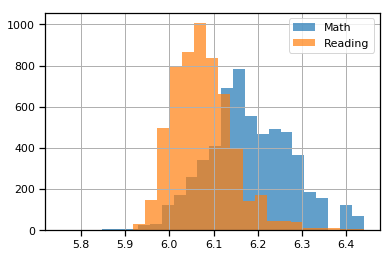

In [15]:
log_math = np.log(df.math)
log_reading = np.log(df.reading)
df.math.apply(lambda x:np.log(x)).hist(bins=25, alpha = 0.7, label = "Math") # Do we need to add +0.1?
df.reading.apply(lambda x:np.log(x)).hist(bins=25, alpha = 0.7, label = "Reading") # Do we need to add +0.1?
plt.legend()
plt.show()


## Pooled model 

In [16]:
pooled_code = """
data {
    int<lower=0>  N;
    vector[N] x;
    vector[N] y1;
    vector[N] y2;
}
parameters {
    vector[2] beta1;
    real<lower=0> sigma1;
    vector[2] beta2;
    real<lower=0> sigma2;
    
}
model {
    y1 ~ normal(beta1[1] + beta1[2]*x, sigma1);
    y2 ~ normal(beta2[1] + beta2[2]*x, sigma2);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y1[i]| beta1[1] + beta1[2]*x[i], sigma1);
}

"""

In [17]:
import pystan

pool_data = {
    'N': df.shape[0], #schooled 
    'x': df.loc[:,'year_teaching'],
    'y1': log_math,
    'y2': log_reading,
}

In [18]:
pooled_fit = pystan.stan(model_code=pooled_code, data = pool_data, iter = 1000, chains = 2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_33cb4cfb1ea8e2a5af90eaf963c41f98 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp3fzhxiav/stanfit4anon_model_33cb4cfb1ea8e2a5af90eaf963c41f98_13726613038028668.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [36]:
pooled_sample = pooled_fit.extract(permuted=True)

loglik = (pooled_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("elpd_loo: ",psisloo.elpd)
#psisloo.plot()
lppd_pooled = 0 
for i in range (5748):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print(peff_pooled)

elpd_loo:  5261.320358739571
3.218777200081604


In [33]:
print(loglik.shape)

(1000, 5748)


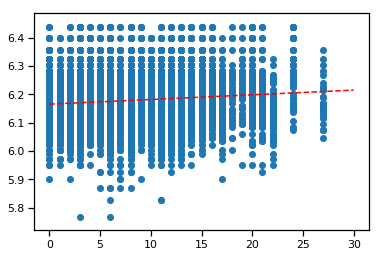

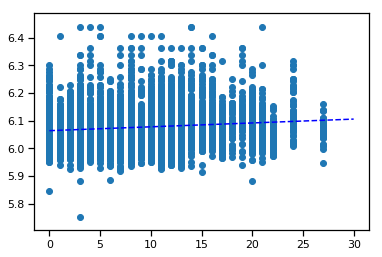

In [26]:
b0, m0 = pooled_sample['beta1'].T.mean(1)
plt.scatter(df.year_teaching, log_math)
xvals = np.linspace(0,30)
plt.plot(xvals, m0*xvals+b0, 'r--')
plt.show()

b0, m0 = pooled_sample['beta2'].T.mean(1)
plt.scatter(df.year_teaching, log_reading)
xvals = np.linspace(0,30)
plt.plot(xvals, m0*xvals+b0, 'b--')
plt.show()

##  Separate model

In [27]:
separate_code = """
data{
    int<lower=0> N;
    int<lower=1, upper=79> school[N]; #school indicator
    vector[N] x;
    vector[N] y;
}
parameters {
    vector[79] alpha;
    real beta; #only 1 beta, not a vector
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] y_hat;  
    for (i in 1:N)
        y_hat[i] <- beta* x[i] + alpha[school[i]];
}
model {
    y ~ normal(y_hat, sigma);
}
generated quantities{
    vector[N] log_lik;
    for (i in 1:N)
     log_lik[i] = normal_lpdf(y[i]| y_hat[i], sigma);
}
"""

In [28]:
separate_data = {'N': df.shape[0],
                 'school': star.schidkn,
                 'x': df.loc[:,'year_teaching'],
                 'y': log_math }

In [29]:
separate_fit = pystan.stan(model_code = separate_code, data = separate_data, iter = 1000, chains = 2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0658457e53e8959415aa44ade4e33d07 NOW.
/opt/conda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp_1rjwg2x/stanfit4anon_model_0658457e53e8959415aa44ade4e33d07_6410101438156544898.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [30]:
print(separate_fit)
separate_sample = separate_fit.extract(permuted=True)


Inference for Stan model: anon_model_0658457e53e8959415aa44ade4e33d07.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]        6.19  3.4e-4   0.01   6.17   6.18   6.19    6.2   6.21   1121    1.0
alpha[2]         6.1  3.8e-4   0.01   6.08   6.09    6.1   6.11   6.12   1043    1.0
alpha[3]        6.18  2.6e-4 8.4e-3   6.17   6.18   6.18   6.19    6.2   1040    1.0
alpha[4]        6.14  3.6e-4   0.01   6.12   6.13   6.14   6.15   6.16   1021    1.0
alpha[5]        6.12  3.7e-4   0.01    6.1   6.11   6.12   6.13   6.14   1131    1.0
alpha[6]        6.14  4.0e-4   0.01   6.12   6.13   6.14   6.15   6.17    958    1.0
alpha[7]        6.23  2.6e-4 8.4e-3   6.21   6.22   6.23   6.23   6.24   1052    1.0
alpha[8]        6.15  2.9e-4 8.9e-3   6.14   6.15   6.15   6.16   6.17    913    1.0
alpha[9]        6.17  3.0e-4 8.1e-3   6.16   6.1

elpd_loo:  5261.320358739571
3.218777200081604


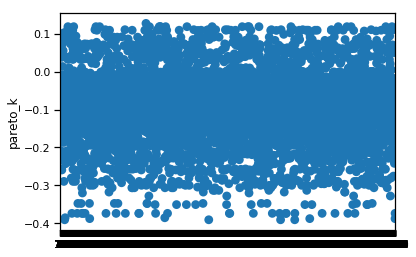

In [37]:
separate_sample = pooled_fit.extract(permuted=True)

loglik = (separate_sample["log_lik"])
psisloo = stanity.psisloo(loglik)
print("elpd_loo: ",psisloo.elpd)
psisloo.plot()
lppd_pooled = 0 
for i in range (5748):
    lppd_pooled = lppd_pooled + np.log(np.mean(np.exp(loglik[:,i])))

peff_pooled = np.sum(lppd_pooled) - psisloo.elpd
print(peff_pooled)

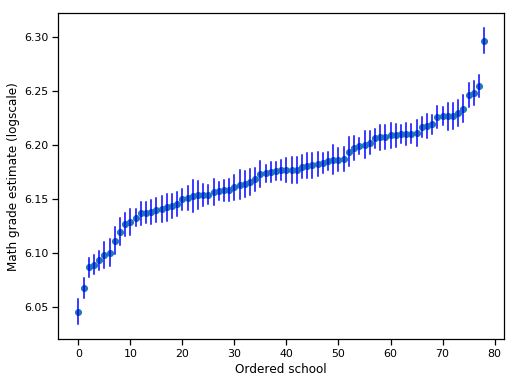

In [32]:
separate_sample = pd.Series(separate_fit['alpha'].mean(0), index=schools)
separate_sample_se = pd.Series(separate_fit['alpha'].std(0), index=schools)

order = separate_sample.sort_values().index
plt.figure(figsize = (8,6))
plt.scatter(range(len(separate_sample)), separate_sample[order])
for i, m, se in zip(range(len(separate_sample)), separate_sample[order], separate_sample_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.ylabel('Math grade estimate (logscale)');plt.xlabel('Ordered school');